In [1]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
# Loading your IBM Quantum account(s)
token = IBMQ.save_account('24f9b17bb2ed402e361d6135ce47685773353c2456e773993f11cffbc7d378f47c760784f62935349429e848999e1029cc97eead6c183bd45a5bb1ce9c784628')

configrc.store_credentials:WARNING:2022-07-08 13:07:07,165: Credentials already present. Set overwrite=True to overwrite.


In [19]:
def all_error(circ, qubits):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error
    from qiskit.providers.ibmq.job import job_monitor
    
    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    all_err = NoiseModel()
    all_err.add_all_qubit_quantum_error(re_err,"reset")
    all_err.add_all_qubit_quantum_error(meas_err,"measure")
    all_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    all_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    
    
       # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        all_err.add_quantum_error(errors_reset[j], "reset", [j])
        all_err.add_quantum_error(errors_measure[j], "measure", [j])
        all_err.add_quantum_error(errors_u1[j], "u1", [j])
        all_err.add_quantum_error(errors_u2[j], "u2", [j])
        all_err.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            all_err.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        
    
    
    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    all_err.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    provider = IBMQ.load_account()
    get_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backends = provider.backends()
    print(backends)
    #C = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']
    C = ['ibm_oslo']
    for i in range(len(C)):
        
        
        backend = provider.get_backend(C[i])
        if(backend.configuration().n_qubits > 2):
            print(backend, end='\n')
            noise_model = NoiseModel.from_backend(backend)
            print(noise_model, end='\n')
            coupling_map = backend.configuration().coupling_map
            basis_gates = noise_model.basis_gates
            print(basis_gates, end='\n')
            noise_model = NoiseModel.from_backend(backend).to_dict()
            #noise_model = NoiseModel.from_backend(backend).to_dict()
            #real_hardware_run = transpile(circ, noise_model)
            #qobj = assemble(circ, backend=backend, shots=1024)
        # execute the circuit
            #job = backend.run(qobj)
            real_run = execute(circ, backend= provider.get_backend(C[i]), coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result()
            #job = backend.run(real_run, shots= 1024)
            #print(real_run.job_id(), end='\n')
            #job_monitor(real_run)
            counts = real_run.get_counts()
            plot_bit= plot_histogram(counts)
            display(plot_bit)
            sim_noise = AerSimulator(noise_model=all_err)
    
            tnoise = transpile(circ, sim_noise)
            result_all_err = sim_noise.run(tnoise).result()
            counts_all_err = result_all_err.get_counts()
    
    
            legend = ['real_device', 'simulated_noise']
            plot_bit = plot_histogram([counts, counts_all_err], legend= legend)
            display(plot_bit)
    
    
            num_binary_states = 2**qubits

            # get the total counts for two dictionaries
            N1 = sum(counts.values())
            N2 = sum(counts_all_err.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
            for number in range(2**qubits):
            
            
            
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
                binary_state = '{0:b}'.format(number).zfill(qubits)

                if binary_state not in counts:
                    
        
                    counts[binary_state] = 0
        
                if binary_state not in counts_all_err:
                
                    counts_all_err[binary_state] = 0

    # following loop actually computes the TVD between two distributions
            tvd = 0
            print(' TVD Distribution')
            for key in counts:
                print(key)
                print(counts[key], counts_all_err[key])
                tvd = tvd + 0.5 * abs(counts[key]/N1 - counts_all_err[key]/N2)
                print(tvd)
    
    
            print('Jensen-Shannon Distance')
            from scipy.spatial import distance
            a = counts.values()
            b = counts_all_err.values()
            data_a = list(a)
            data_b = list(b)
            arr_a = np.array(data_a)
            arr_b = np.array(data_b)
            jsd = distance.jensenshannon(arr_a, arr_b)
            print(jsd)
    
            print('Hellinger Distance') 
            _SQRT2 = np.sqrt(2)
            hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
            print(hell1)
            hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
            print(hell2)
            hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
            print(hell3)
            
    
    
    
    return plot_bit, tvd, jsd, hell1, hell2, hell3

In [12]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

┌───┐          ┌─┐      
q38_0: ┤ H ├──■───────┤M├──────
       └───┘┌─┴─┐     └╥┘┌─┐   
q38_1: ─────┤ X ├──■───╫─┤M├───
            └───┘┌─┴─┐ ║ └╥┘┌─┐
q38_2: ──────────┤ X ├─╫──╫─┤M├
                 └───┘ ║  ║ └╥┘
 c2: 3/════════════════╩══╩══╩═
                       0  1  2

ibmqfactory.load_account:WARNING:2022-07-08 14:10:41,145: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibmq_lima


C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
['cx', 'id', 'reset', 'rz', 'sx', 'x']


C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.

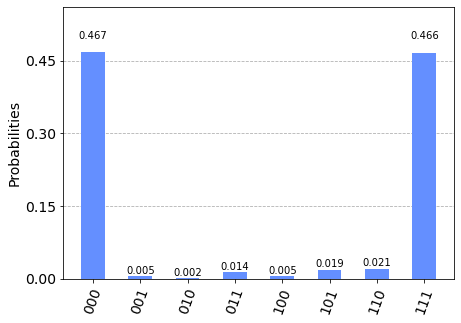

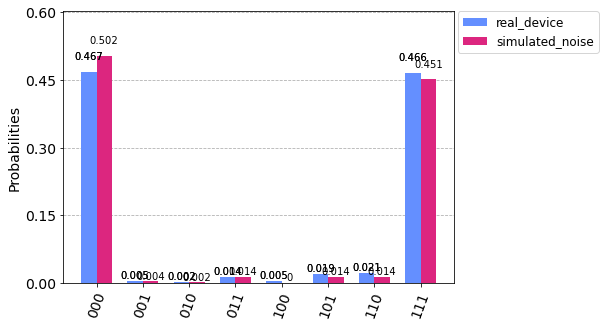

 TVD Distribution
000
1866 514
0.017726562499999987
001
21 4
0.018398437499999986
010
8 2
0.018421874999999987
011
55 14
0.018460937499999986
100
22 0
0.021210937499999985
101
78 14
0.024124999999999987
110
85 14
0.02791406249999999
111
1865 462
0.03545312499999999
Jensen-Shannon Distance
0.5617006368482568
Hellinger Distance
36.67565059745826
36.67565059745826
36.67565059745826
ibmq_belem
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('rese

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


IBMQJobFailureError: 'Unable to retrieve result for job 62c7e97a1e73ff8331f61ab9. Job has failed: Failed to run job.. Error code: 5203.'

In [15]:
all_error(ghz_circ, len(q_ghz))

In [16]:
#Mermin_Bell gate
from math import pi
mer_bell = QuantumRegister(3)
mer_bell_c =  ClassicalRegister(3)
mer_bell_circ = QuantumCircuit(mer_bell, mer_bell_c)
mer_bell_circ.rx(-pi/2, mer_bell[0])
mer_bell_circ.cx(mer_bell[0], mer_bell[1])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cx(mer_bell[0], mer_bell[2])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.cx(mer_bell[2], mer_bell[0])
mer_bell_circ.cx(mer_bell[1], mer_bell[0])
mer_bell_circ.s(mer_bell[2])
mer_bell_circ.s(mer_bell[0])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cz(mer_bell[0], mer_bell[1])
mer_bell_circ.h(mer_bell[0])
mer_bell_circ.s(mer_bell[1])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.measure(mer_bell[0:3], mer_bell_c[0:3])
display(mer_bell_circ.draw())
                           

┌──────────┐                         ┌───┐┌───┐┌───┐   ┌───┐     ┌─┐   
q82_0: ┤ Rx(-π/2) ├──■──────────────■───────┤ X ├┤ X ├┤ S ├─■─┤ H ├─────┤M├───
       └──────────┘┌─┴─┐     ┌───┐  │       └─┬─┘└─┬─┘└───┘ │ ├───┤┌───┐└╥┘┌─┐
q82_1: ────────────┤ X ├──■──┤ H ├──┼────■────┼────■────────■─┤ S ├┤ H ├─╫─┤M├
                   └───┘┌─┴─┐├───┤┌─┴─┐┌─┴─┐  │  ┌───┐┌───┐┌─┐└───┘└───┘ ║ └╥┘
q82_2: ─────────────────┤ X ├┤ H ├┤ X ├┤ X ├──■──┤ S ├┤ H ├┤M├───────────╫──╫─
                        └───┘└───┘└───┘└───┘     └───┘└───┘└╥┘           ║  ║ 
 c3: 3/═════════════════════════════════════════════════════╩════════════╩══╩═
                                                            2            0  1

ibmqfactory.load_account:WARNING:2022-07-08 22:52:08,588: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibmq_lima


C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
['cx', 'id', 'reset', 'rz', 'sx', 'x']


C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.

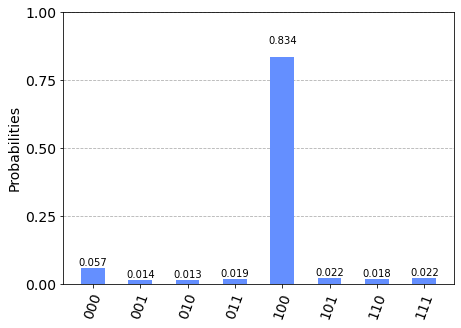

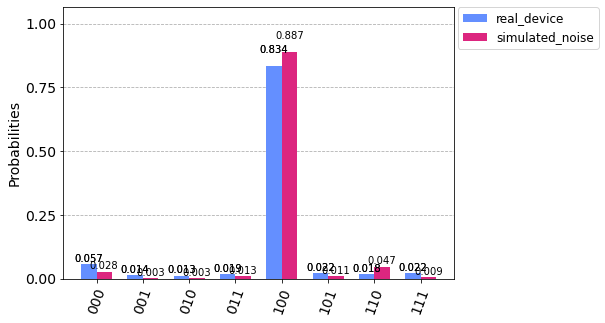

 TVD Distribution
000
229 29
0.014464843750000001
001
57 3
0.020125
010
53 3
0.02528515625
011
77 13
0.028562499999999998
100
3337 908
0.054796874999999974
101
88 11
0.06042578124999998
110
72 48
0.07486328124999998
111
87 9
0.08134374999999998
Jensen-Shannon Distance
0.715378490692336
Hellinger Distance
41.95345294776568
41.95345294776568
41.95345294776568
ibmq_belem
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure',

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


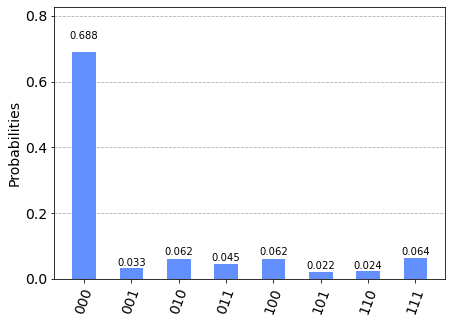

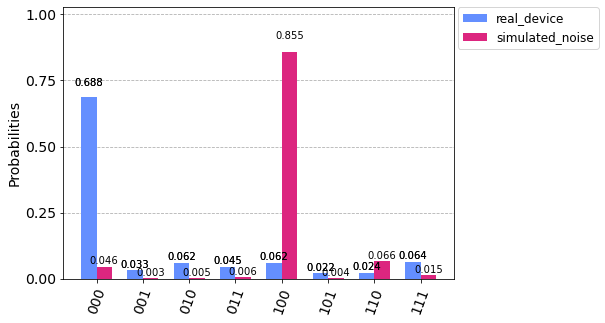

 TVD Distribution
000
2753 47
0.32117578125
001
130 3
0.3359609375
010
249 5
0.36464453125
011
180 6
0.38421484375000003
100
249 876
0.7808242187500001
101
90 4
0.7901210937500001
110
94 68
0.81157421875
111
255 15
0.836125
Jensen-Shannon Distance
0.2304546903301801
Hellinger Distance
24.597342216844883
24.597342216844883
24.597342216844883
ibmq_quito
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


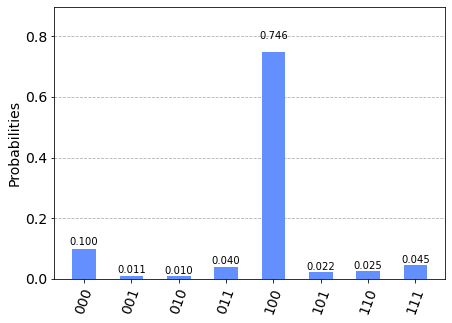

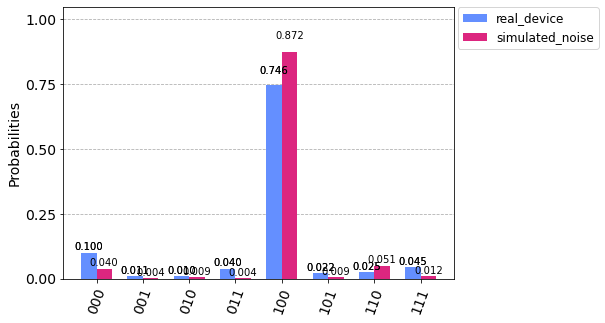

 TVD Distribution
000
401 41
0.030105468750000003
001
45 4
0.03377734375
010
40 9
0.0343828125
011
160 4
0.0524296875
100
2983 893
0.11558984374999999
101
90 9
0.12244531249999999
110
101 52
0.1352109375
111
180 12
0.15185156249999998
Jensen-Shannon Distance
0.6729509554134497
Hellinger Distance
39.83134891058919
39.83134891058919
39.83134891058919
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), 

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


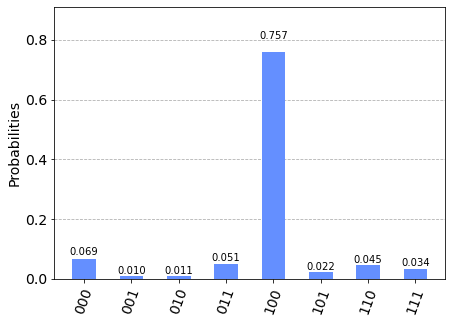

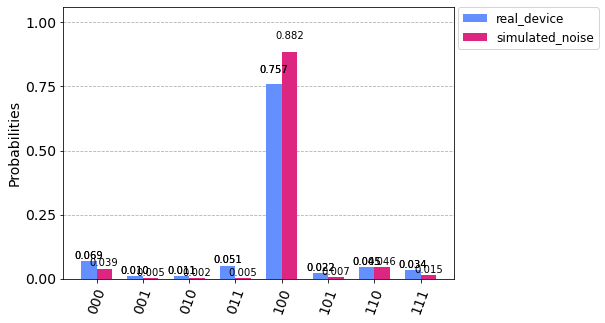

 TVD Distribution
000
274 40
0.014718750000000003
001
41 5
0.017402343750000004
010
44 2
0.021925781250000005
011
206 5
0.04523437500000001
100
3029 903
0.10752734375000002
101
88 7
0.11510937500000001
110
181 47
0.11543359375000001
111
137 15
0.125234375
Jensen-Shannon Distance
0.6917448891054111
Hellinger Distance
40.123205386767964
40.123205386767964
40.12320538676797
ibm_nairobi
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (1, 3)), ('cx', (3

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


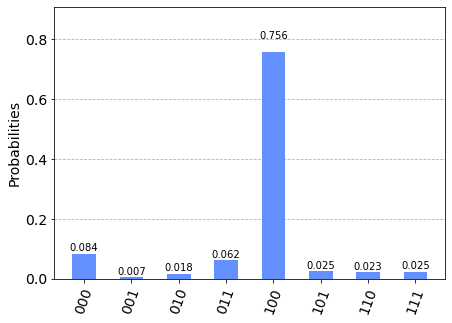

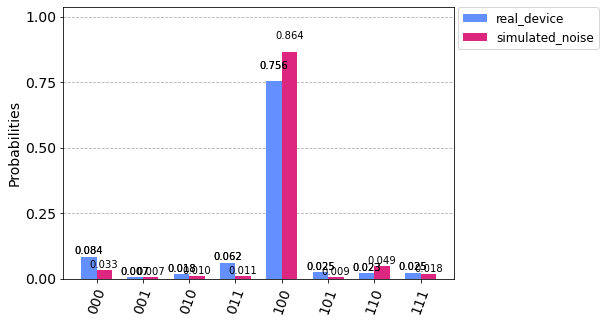

 TVD Distribution
000
337 34
0.025523437500000003
001
30 7
0.025855468750000003
010
71 10
0.02984765625
011
247 11
0.0553515625
100
3025 885
0.10935546875000002
101
101 9
0.11758593750000002
110
91 50
0.13062500000000002
111
98 18
0.13408593750000003
Jensen-Shannon Distance
0.6719904662523201
Hellinger Distance
39.47864250086313
39.47864250086313
39.47864250086313
ibm_oslo
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'sx', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (4, 5)), ('cx', (5, 4)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (5, 3)), ('cx', (3, 5)), ('c

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)
ibmqjob._wait_for_completion:ERROR:2022-07-09 10:45:55,389: Maximum retries exceeded: Error checking job status due to a network error.


IBMQJobApiError: 'Error checking job status due to a network error: \'HTTPSConnectionPool(host=\\\'api-qcon.quantum-computing.ibm.com\\\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/62c882ff3159f4e1cc9d404e/status/v/1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host=\\\'api-qcon.quantum-computing.ibm.com\\\', port=443): Read timed out. (read timeout=5.0)"))\''

In [18]:
all_error(mer_bell_circ, len(mer_bell))

ibmqfactory.load_account:WARNING:2022-07-09 11:15:34,411: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibm_oslo
NoiseModel:
  Basis gates: 

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


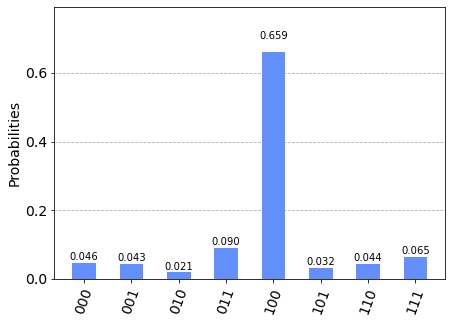

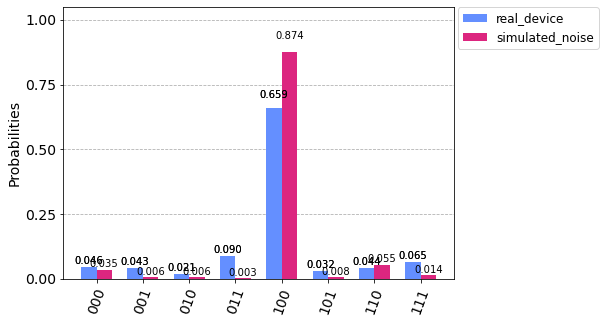

 TVD Distribution
000
184 36
0.005421875
001
172 6
0.023992187499999998
010
82 6
0.0313125
011
360 3
0.07484765625
100
2638 895
0.18210937500000002
101
129 8
0.19432812500000002
110
177 56
0.199546875
111
258 14
0.2249609375
Jensen-Shannon Distance
0.6683031199134917
Hellinger Distance
38.904827547724786
38.904827547724786
38.90482754772479


(<Figure size 504x360 with 1 Axes>,
 0.2249609375,
 0.6683031199134917,
 38.904827547724786,
 38.904827547724786,
 38.90482754772479)

In [20]:
all_error(mer_bell_circ, len(mer_bell))